# Self-Driving Car Engineer Nanodegree

## Project: Advanced Lane Lines Finding on the Road


In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project.  Check out the [writeup](https://github.com/jay-thakur/Advanced-Lane-Finding/blob/master/writeup.md) for this project.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

The `challenge_video.mp4` video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  The `harder_challenge.mp4` video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there!  We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!


## 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

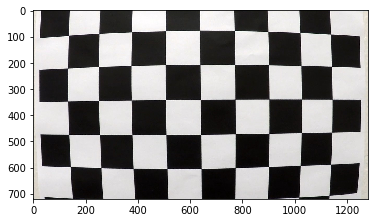

In [2]:
img = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(img)

Found corners in 17 images.


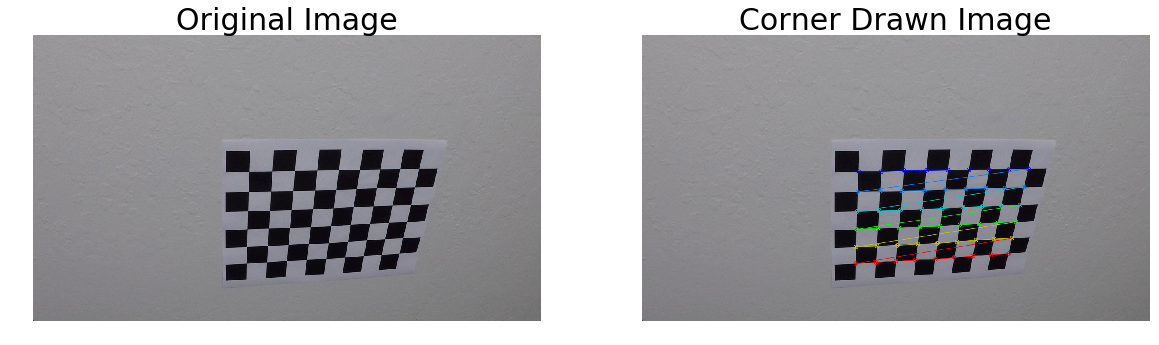

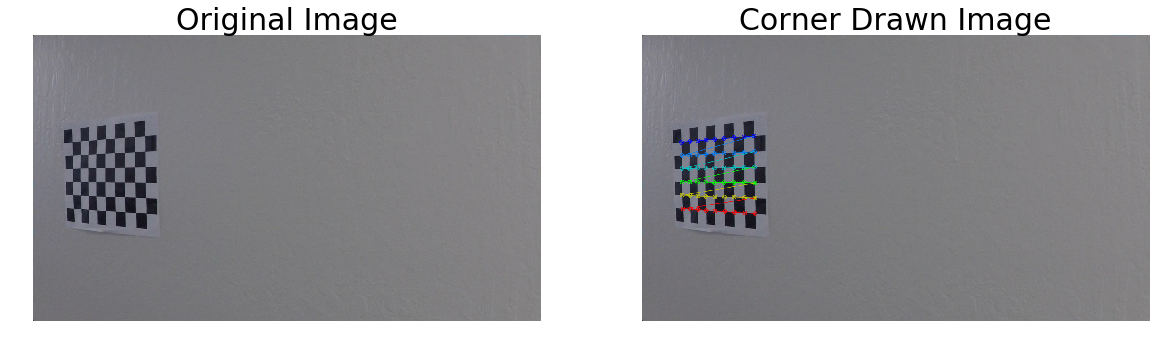

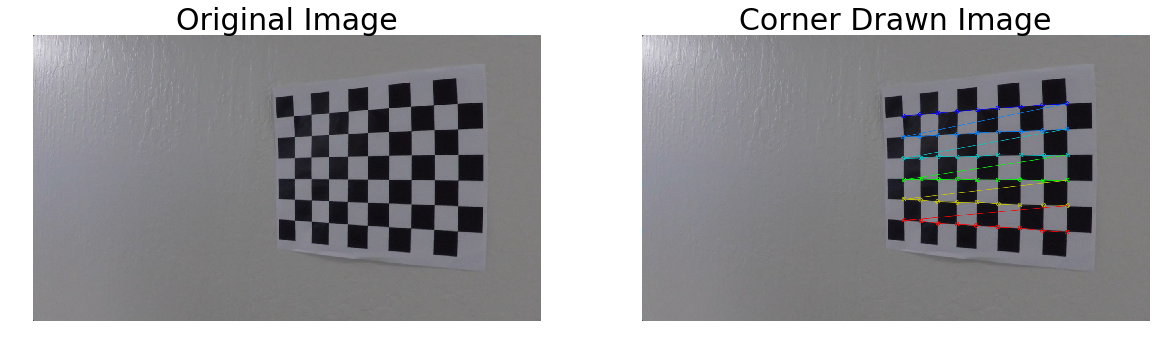

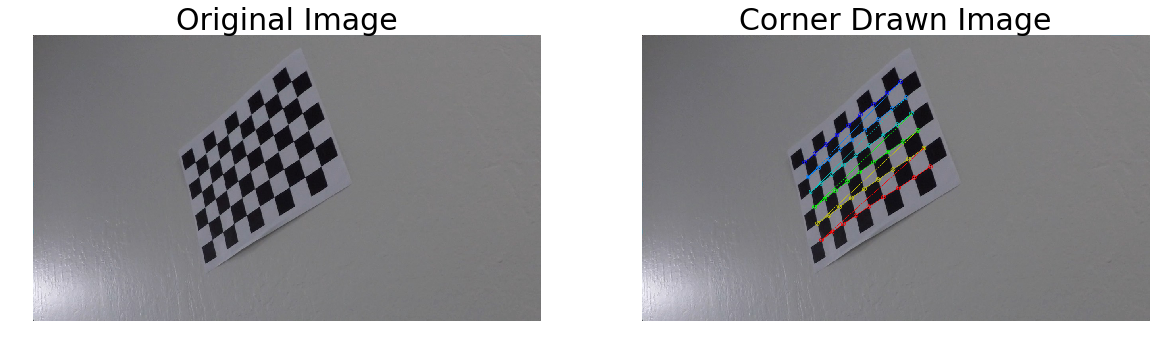

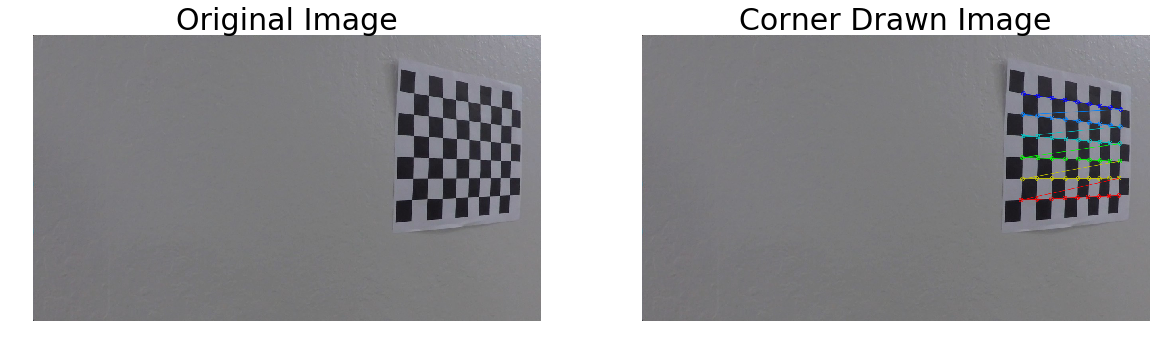

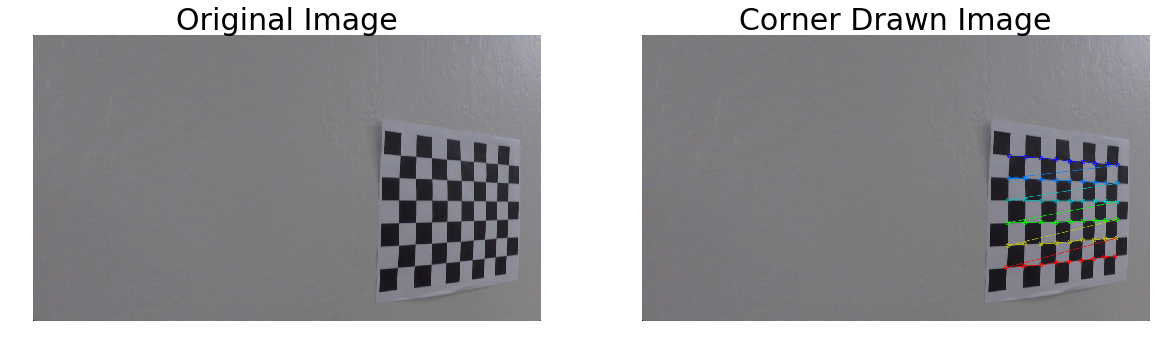

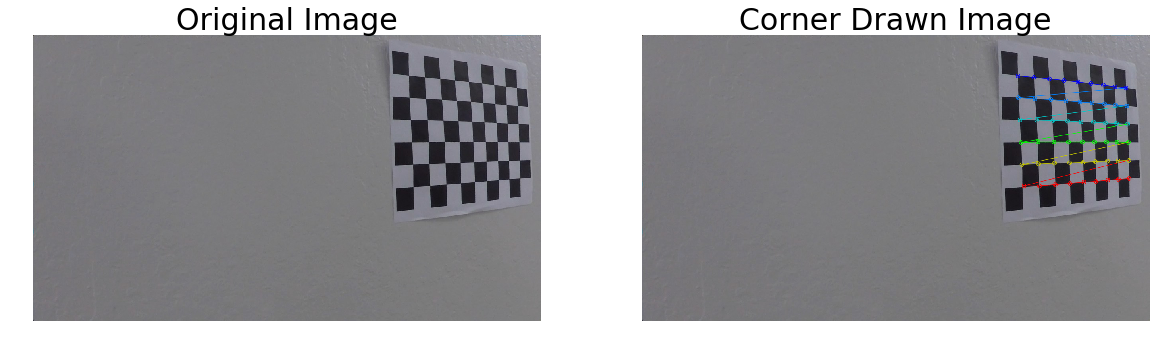

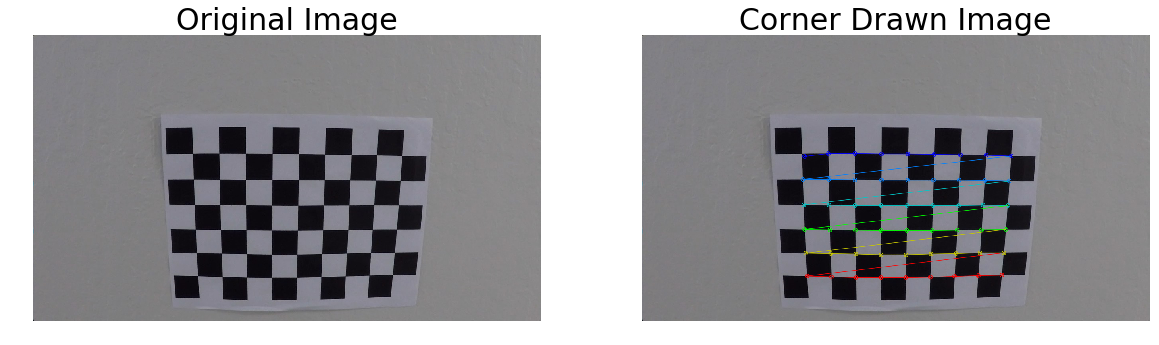

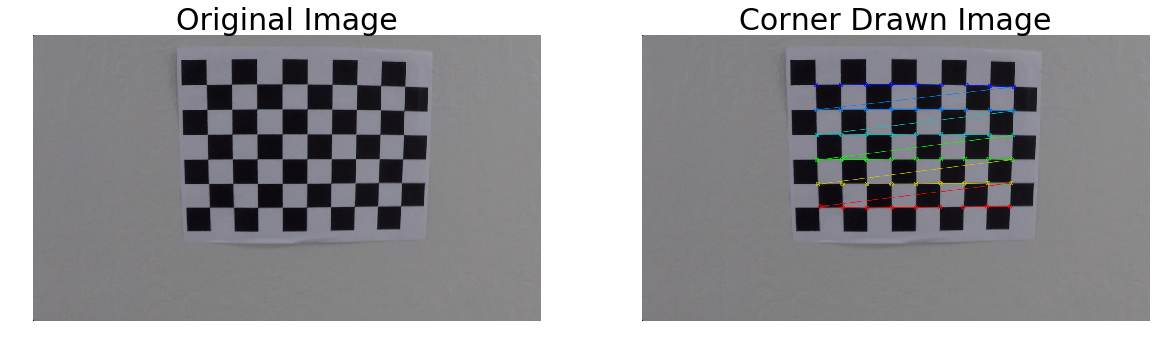

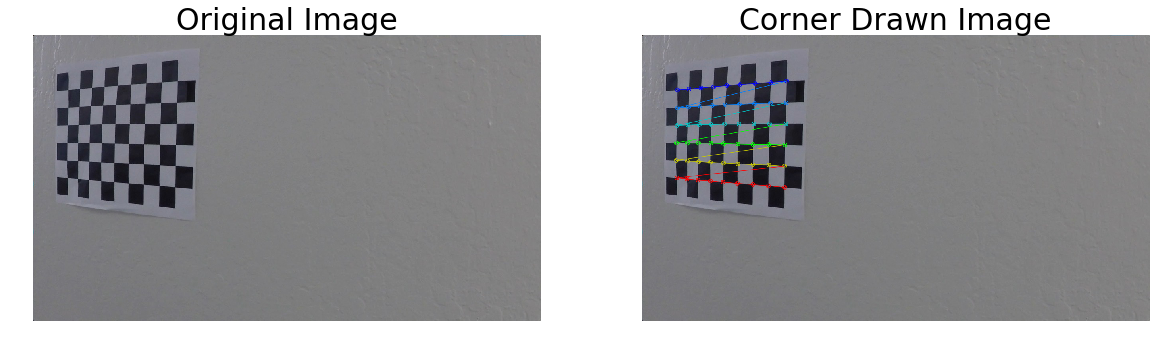

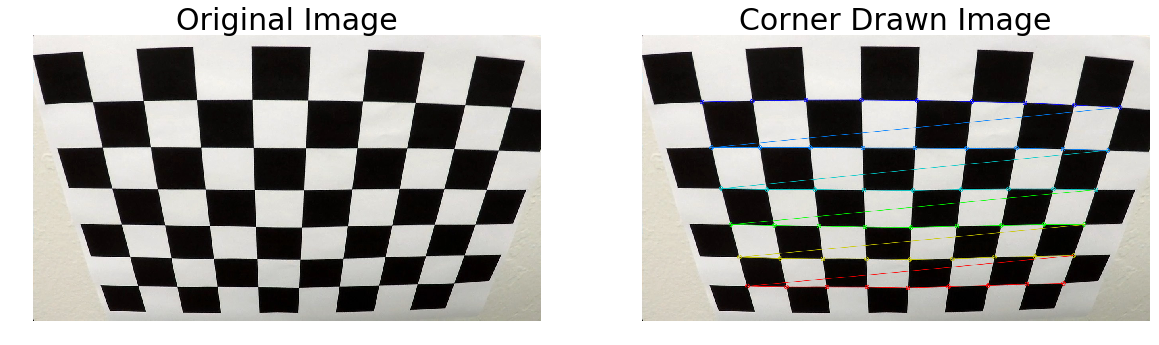

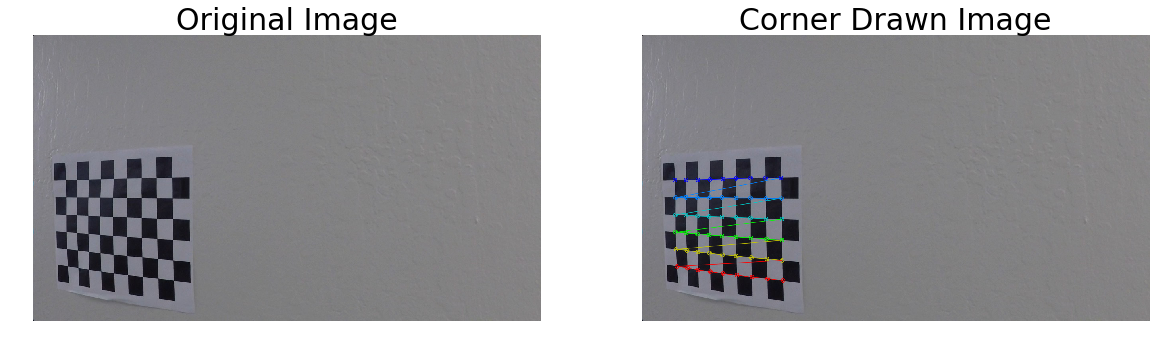

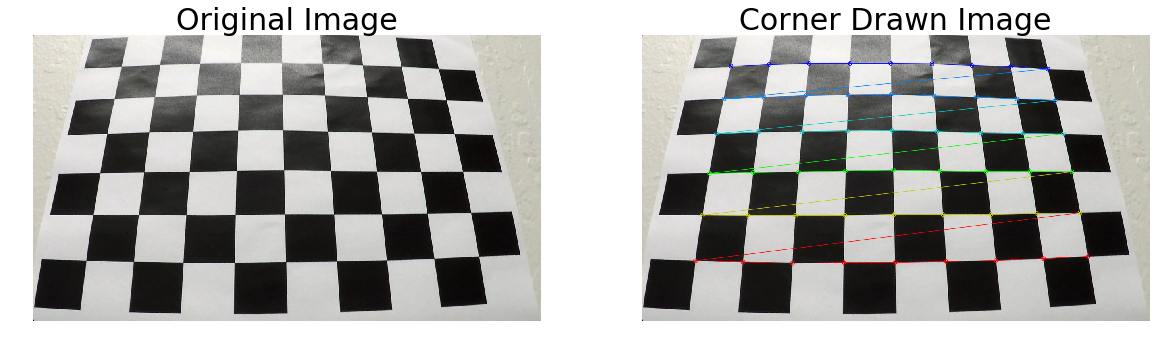

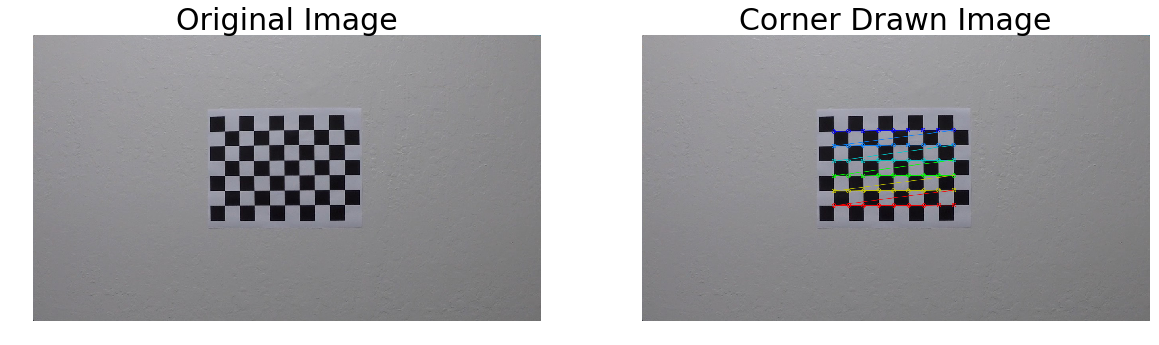

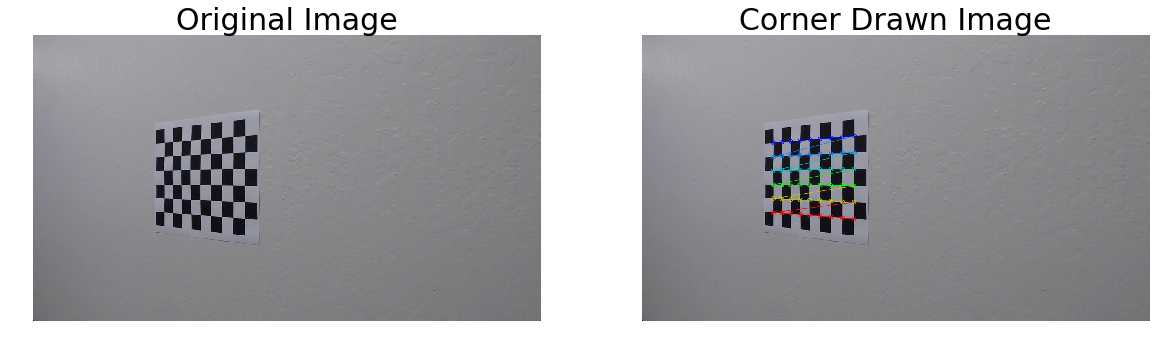

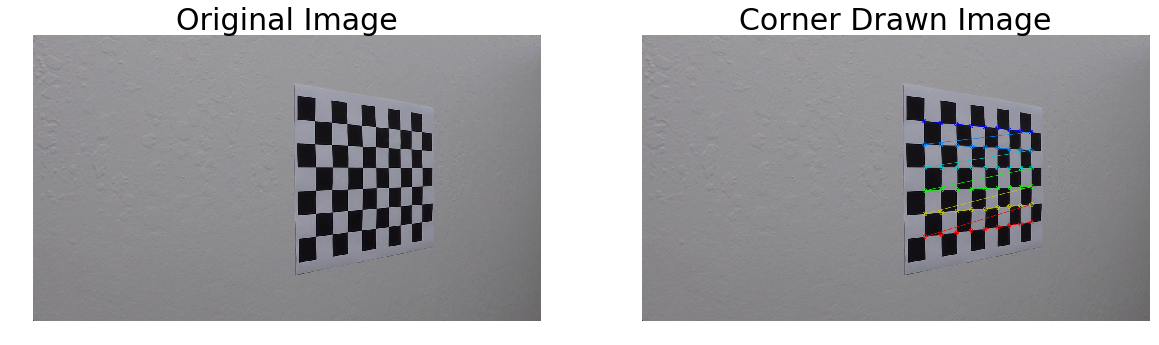

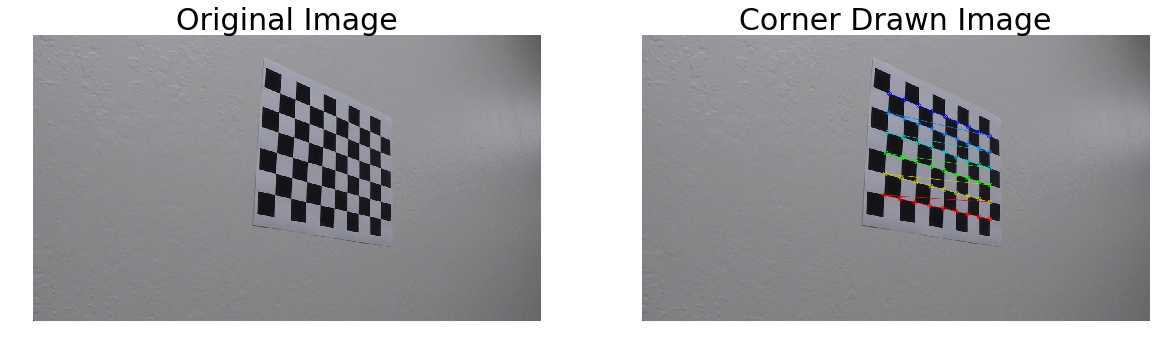

In [3]:
# Read in and Make a list of all calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Array to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image place

# Prepare object points like (0,0,0), (1,0,0), (2,0,0).......(7,5,0),
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    image = np.copy(img) # Keep a copy of original image
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)    

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None) # last parameter if we have any flag, in this case we have none

    # if corners found, add object points, image points    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(image)
        ax1.axis("off")
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(img)
        ax2.axis("off")
        ax2.set_title('Corner Drawn Image', fontsize=30)
        
        # Save Corner Drawn Image into output_images folder
        filename = fname.split('\\')[-1:][0]        
        output_path = 'output_images/'+filename
        cv2.imwrite(output_path, img)        

print("Found corners in " +str(len(objpoints)) + " images.")

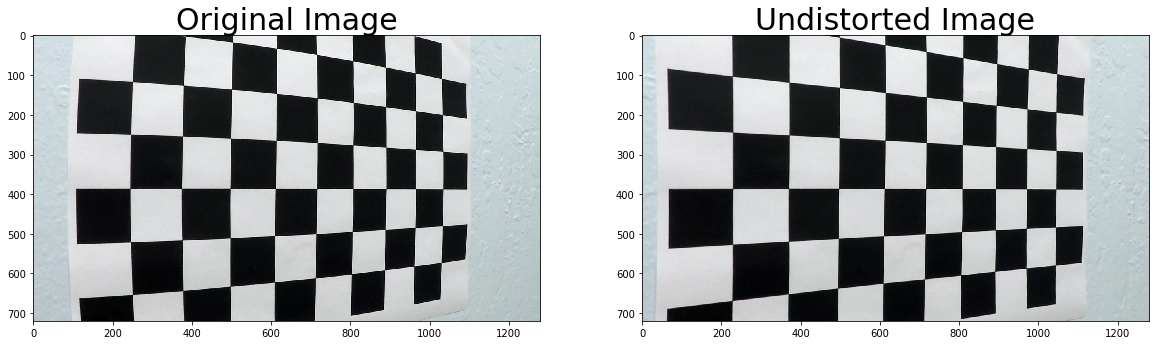

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Display Original & Undistorted Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        
        offset = 100 # offset for dst points
        
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])
        
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # Warp the image using OpenCV warpPerspective()        
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

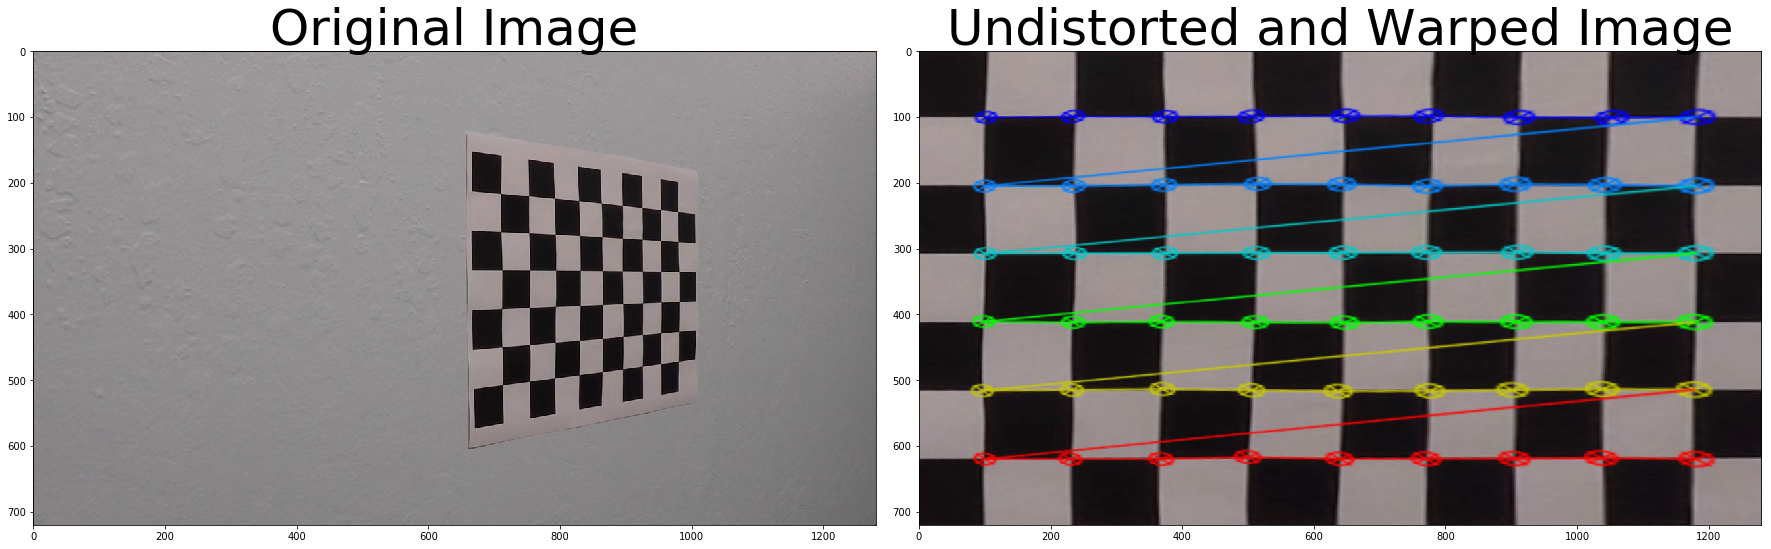

In [6]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration8.jpg')
# img_size = (img.shape[1], img.shape[0])

top_down, perspective_M = corners_unwarp(img, 9, 6, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Image Thresholding

In [7]:
def binary_transform(img, sobel_kernel=3, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Apply a threshold to the S channel    
    s_channel = hls[:,:,2]
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely)
    
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary,combined_binary    

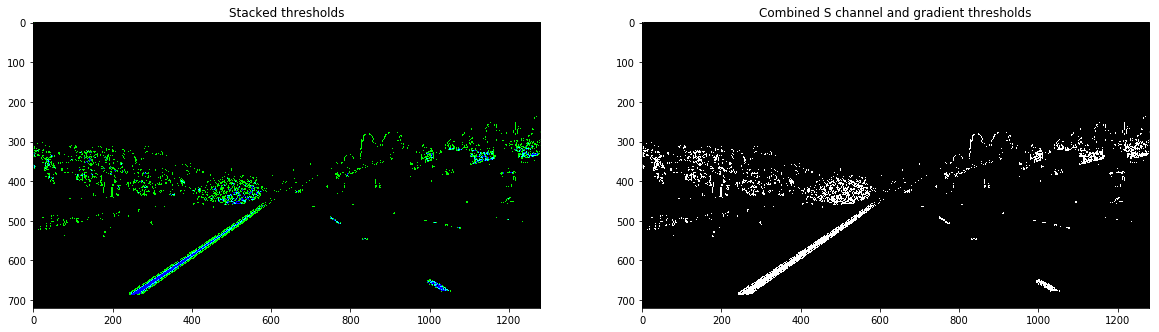

In [8]:
img = mpimg.imread('test_images/straight_lines1.jpg')

original_img = np.copy(img)

result = binary_transform(img)
color_binary = result[0]
combined_binary = result[1]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## 3.  Perspective Transform

In [9]:
def birds_eye_view(combined_binary):
    img_size = (combined_binary.shape[1], combined_binary.shape[0])
    
    offset = 200

    src = np.float32([
        [  588,   446 ],
        [  691,   446 ],
        [ 1126,   673 ],
        [  153 ,   673 ]])

    dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    return M, Minv, binary_warped

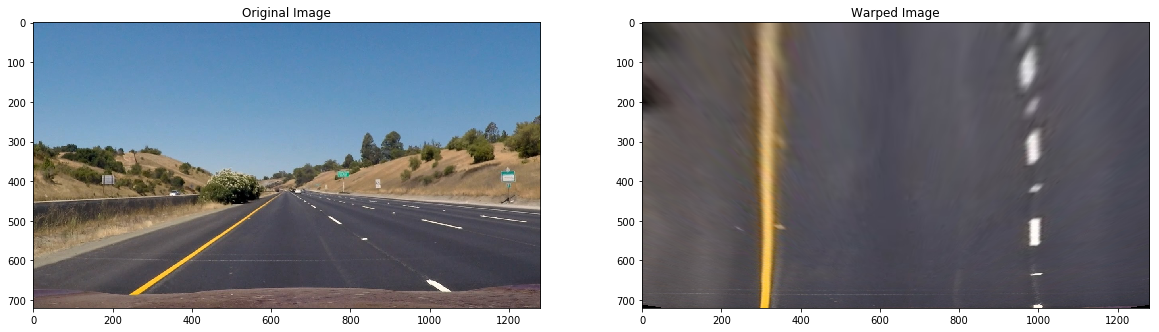

In [10]:
M, Minv, binary_warped = birds_eye_view(original_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(original_img)

ax2.set_title('Warped Image')
ax2.imshow(binary_warped, cmap='gray')

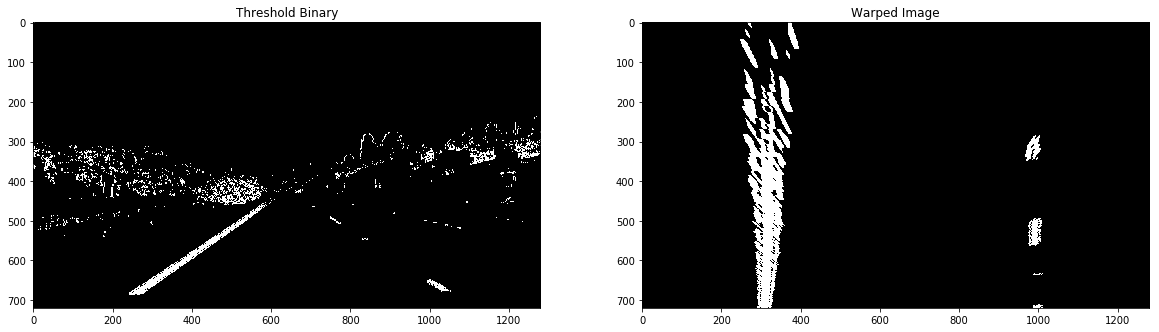

In [11]:
M, Minv, binary_warped = birds_eye_view(combined_binary)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Threshold Binary')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('Warped Image')
ax2.imshow(binary_warped, cmap='gray')

## 4. Lane Detection & Fit With Polynomial

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [13]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img

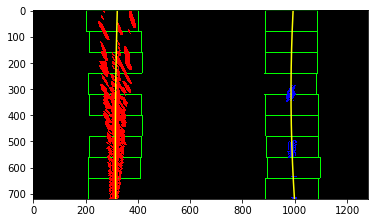

In [14]:
leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)

# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

## 5. Radius of Curvature & Distance from Center

In [15]:
def measure_curvature_real(left_fitx, right_fitx, ploty):
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension

    y_eval = np.max(ploty/2)*ym_per_pix

    left_curverad = (2*left_fitx[0]*y_eval + left_fitx[1])*xm_per_pix/ym_per_pix
    right_curverad = 2*left_fitx[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    
    # distance from circle    
    dist_from_center = (640 - (left_fitx[-1] + right_fitx[-1])//2)*xm_per_pix # assuming 1280*720 size
    
    return left_curverad, right_curverad, dist_from_center

In [16]:
# Calculate the radius of curvature in meters for both lane lines
def cal_curvature(left_fitx, right_fitx, ploty):    
    left_curverad, right_curverad, dist_from_center = measure_curvature_real(left_fitx, right_fitx, ploty)
    curvature = ((1 + left_curverad*left_curverad)**(1.5))/np.absolute(right_curverad)
    
    return left_curverad, right_curverad, curvature, dist_from_center

left_curverad, right_curverad, curvature, dist_from_center = cal_curvature(left_fitx, right_fitx, ploty)

print("Radius of Curvature is: %f" % curvature)
print(left_curverad, 'm,', right_curverad, 'm')

if dist_from_center < 0:
    text = 'left'
else:
    text = 'right'

print('Vehicle is {:04.3f}'.format(np.absolute(dist_from_center)) + ' m ' + text + ' from center')

Radius of Curvature is: 1156005.124908
1338.789089426892 m, 2075.759800864963 m
Vehicle is 0.095 m left from center


## 6. Plotting Idendified lanes

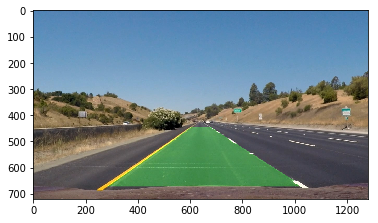

In [17]:
def plot_identified_lanes(image, binary_warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image

    return cv2.addWeighted(image, 1, newwarp, 0.3, 0)

result = plot_identified_lanes(original_img, binary_warped, Minv, left_fitx, right_fitx, ploty)
plt.imshow(result)

##  Pipeline for Video Processing

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def lane_finding_pipeline(image):     
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    _, binary = binary_transform(undist)

    M, Minv, warped = birds_eye_view(binary)
    
    leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty, out_img = fit_polynomial(warped)

    left_curverad, right_curverad, curvature, dist_from_center = cal_curvature(left_fitx, right_fitx, ploty)
    
    final_output = plot_identified_lanes(image, warped, Minv, left_fitx, right_fitx, ploty)
    
    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
        
    roc_text = "Radius of Curvature: {:.0f} m".format(curvature)
    cv2.putText(final_output, roc_text, (20,50), font, 1, (255,255,255), 2)

    if dist_from_center < 0:
        direction = 'left'
    else:
        direction = 'right'
    dist_text = 'Vehicle is {:04.3f}'.format(np.absolute(dist_from_center)) + ' m ' + direction + ' from center'
    cv2.putText(final_output, dist_text, (20,100), font, 1, (255,255,255), 2)

    #return np.hstack((final_output, out_img))
    return final_output

In [20]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below         
    # you should return the final output (image where lines are drawn on lanes)
    return lane_finding_pipeline(image)

In [21]:
project_video_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:03<00:00,  4.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 5s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))